# MIP Experiment

In [10]:
import sys
sys.path.append('..')

In [11]:
%matplotlib notebook  
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import scipy as sp
import scipy.signal as signal

In [12]:
from ctrl.system.tf import PID
from ctrl.block.linear import MIMO, ShortCircuit, Subtract, Differentiator
from ctrl.block.logger import Logger
from ctrl.block.nl import Abs
from ctrl.block.logic import CompareAbs, Trigger
from ctrl.system.tf import DTTF
from ctrl.system.ss import DTSS

from ctrl.block import Signal

In [13]:
from ctrl.client import Controller
HOST, PORT = "localhost", 9999
#HOST, PORT = "192.168.0.10", 9999
mip = Controller(host = HOST, port = PORT)

# Probe the controller

In [14]:
print(mip.info('all'))

> Controller with 6 device(s), 9 signal(s), 4 source(s), 2 sink(s), and 0 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. is_running
  6. motor1
  7. motor2
  8. theta
  9. theta_dot
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw2, enabled] >> theta, theta_dot
> filters
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]



# Complementary Filter

In [15]:
Ts = 0.01
fc = 10
l = 2 * math.pi * fc
a = math.exp(-l*Ts)

Af = np.array([[a]])
Bf = np.array([[1-a,(1-a)/l]])
Cf = np.array([[1],[0]])
Df = np.array([[0,0],[0,1]])

fltr = DTSS(Af,Bf,Cf,Df)

mip.add_signal('imu_fltr')
mip.add_filter('fltr', 
               MIMO(fltr),
               ['theta','theta_dot'], 
               ['imu_fltr'])

In [16]:
mip.add_sink('logger', 
             Logger(), 
             ['clock',
              'theta','theta_dot','imu_fltr'])

In [17]:
print(mip.info('all'))

> Controller with 6 device(s), 10 signal(s), 4 source(s), 3 sink(s), and 1 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu_fltr
  6. is_running
  7. motor1
  8. motor2
  9. theta
  10. theta_dot
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw2, enabled] >> theta, theta_dot
> filters
  1. theta, theta_dot >> fltr[MIMO, enabled] >> imu_fltr
> sinks
  1. motor1 >> motor1[Motor, enabled]
  2. motor2 >> motor2[Motor, enabled]
  3. clock, theta, theta_dot, imu_fltr >> logger[Logger, enabled]



In [18]:
with mip:
    time.sleep(10)
log = mip.read_sink('logger')

In [19]:
clock = log[:,0]
theta = log[:,1]
theta_dot = log[:,2]
theta_fltr = log[:,3]
theta_dot_fltr = log[:,4]

<IPython.core.display.Javascript object>


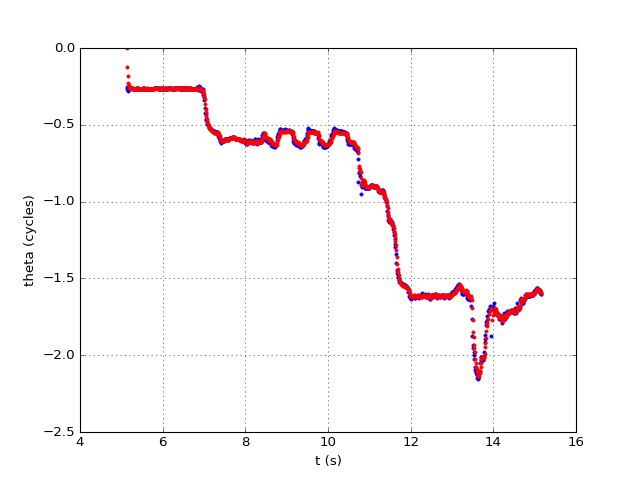

In [20]:
fig = plt.figure()

plt.plot(clock,theta,'.b',clock,theta_fltr,'.r')
plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)

<IPython.core.display.Javascript object>


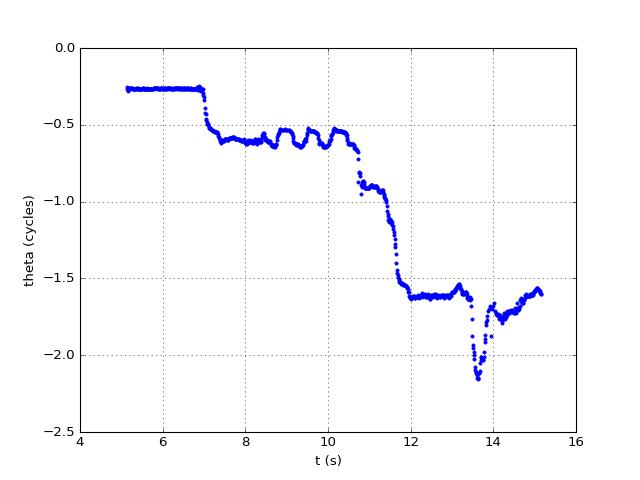

In [21]:
fig = plt.figure()

plt.plot(clock,theta,'.b')
plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)

<IPython.core.display.Javascript object>


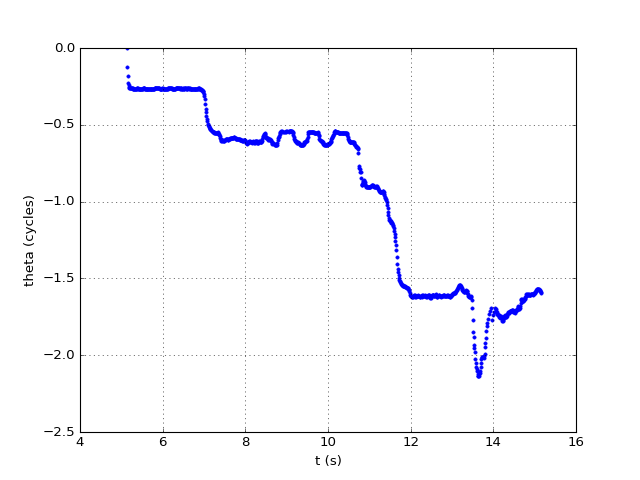

In [22]:
fig = plt.figure()

plt.plot(clock,theta_fltr,'.')

plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)

# Chirp Signal Test

In [138]:
T = 20
t = np.linspace(0,T-Ts,T/Ts)
f0 = 1
f1 = 2
t1 = T
u = signal.chirp(t, f0, t1, f1, method='logarithmic', phi=90)
u = np.hstack((u,np.flipud(u)))
t = np.hstack((t,t+T))
T = 2*T
u = np.hstack((u,-np.flipud(u)))
t = np.hstack((t,t+T))
T = 2*T

<IPython.core.display.Javascript object>


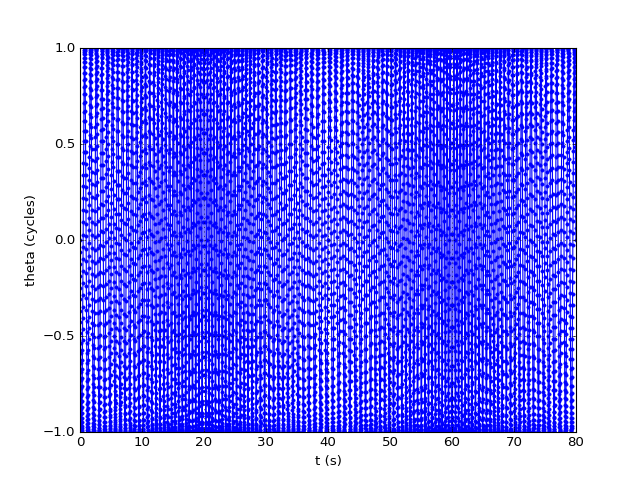

In [139]:
fig = plt.figure()

plt.plot(t,u,'.-')

plt.xlabel('t (s)')
plt.ylabel('theta (cycles)')
plt.grid()
#plt.xlim(0,1)

In [140]:
U = np.fft.fft(u)
w = np.fft.fftfreq(t.shape[-1])

<IPython.core.display.Javascript object>


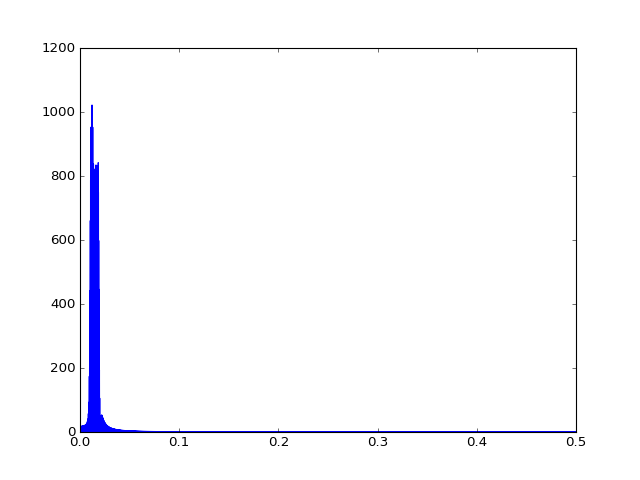

(0, 0.5)

In [141]:
fig = plt.figure()

plt.plot(w, np.absolute(U))
plt.xlim(0,0.5)

# Experiment

In [142]:
mip.add_signal('voltage')
mip.add_source('chirp', Signal(30*u), ['voltage'])

In [143]:
mip.add_filter('cl1',
                ShortCircuit(),
               ['voltage'],
               ['motor1'])
mip.add_filter('cl2',
                ShortCircuit(),
               ['voltage'],
               ['motor2'])

In [144]:
mip.add_sink('logger', 
             Logger(), 
             ['clock',
              'theta','theta_dot','imu_fltr',
              'voltage',
              'motor1','motor2',
              'encoder1','encoder2'])

In [145]:
print(mip.info('all'))

> Controller with 6 device(s), 11 signal(s), 5 source(s), 3 sink(s), and 3 filter(s)
> devices
  1. encoder1[source]
  2. encoder2[source]
  3. clock[source]
  4. motor2[sink]
  5. motor1[sink]
  6. imu[source]
> signals
  1. clock
  2. duty
  3. encoder1
  4. encoder2
  5. imu_fltr
  6. is_running
  7. motor1
  8. motor2
  9. theta
  10. theta_dot
  11. voltage
> sources
  1. clock[Clock, enabled] >> clock
  2. encoder1[Encoder, enabled] >> encoder1
  3. encoder2[Encoder, enabled] >> encoder2
  4. imu[InclinometerRaw2, disabled] >> theta, theta_dot
  5. chirp[Signal, enabled] >> voltage
> filters
  1. theta, theta_dot >> fltr[MIMO, enabled] >> imu_fltr
  2. voltage >> cl1[ShortCircuit, enabled] >> motor1
  3. voltage >> cl2[ShortCircuit, enabled] >> motor2
> sinks
  1. motor1 >> motor1[Motor, disabled]
  2. motor2 >> motor2[Motor, disabled]
  3. clock, theta, theta_dot, imu_fltr, voltage, motor1, motor2, encoder1, encoder2 >> logger[Logger, enabled]



In [146]:
mip.set_sink('logger',reset=True)
mip.set_source('chirp',reset=True)
mip.set_source('imu',reset=True)
mip.set_source('clock',reset=True)
mip.set_source('encoder1',reset=True)
mip.set_source('encoder2',reset=True)
with mip:
    time.sleep(T)
log = mip.read_sink('logger')

In [147]:
clock = log[:,0]
theta = log[:,1]
theta_dot = log[:,2]
theta_fltr = log[:,3]
theta_dot_fltr = log[:,4]
voltage = log[:,5]
motor1 = log[:,6]
motor2 = log[:,7]
encoder1 = log[:,8]
encoder2 = log[:,9]

<IPython.core.display.Javascript object>


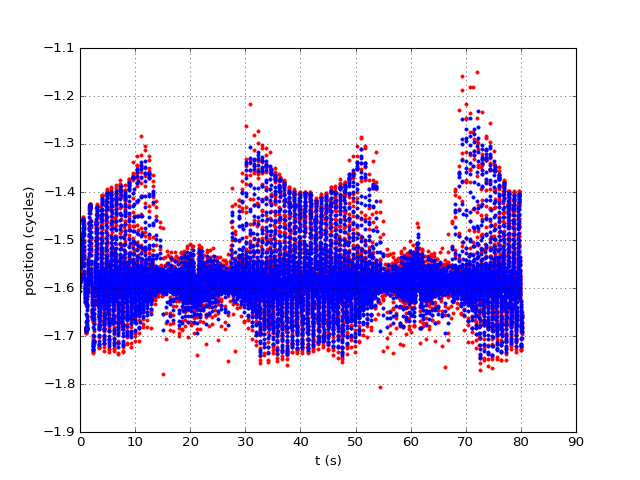

In [149]:
fig = plt.figure()

plt.plot(clock,theta,'r.', clock,theta_fltr, '.b')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

<IPython.core.display.Javascript object>


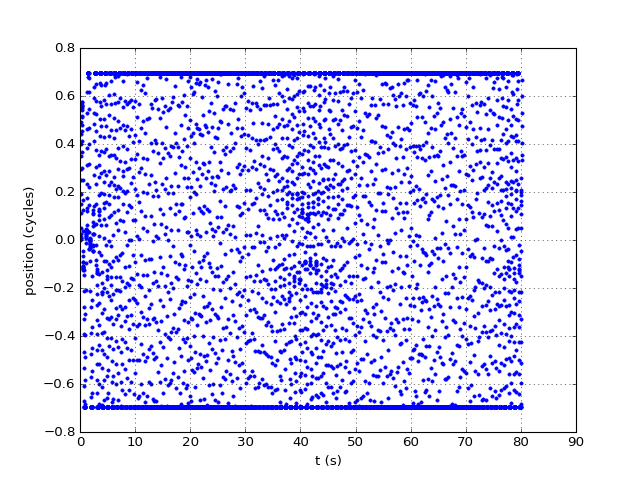

In [150]:
fig = plt.figure()

plt.plot(clock,theta_dot,'.')
plt.xlabel('t (s)')
plt.ylabel('position (cycles)')
plt.grid()

In [151]:
U = np.fft.fft((7.4/100)*voltage)
Y = np.fft.fft(theta_dot)
Y = np.fft.fft(2*np.pi*theta_fltr)
w = np.fft.fftfreq(clock.shape[-1])

<IPython.core.display.Javascript object>


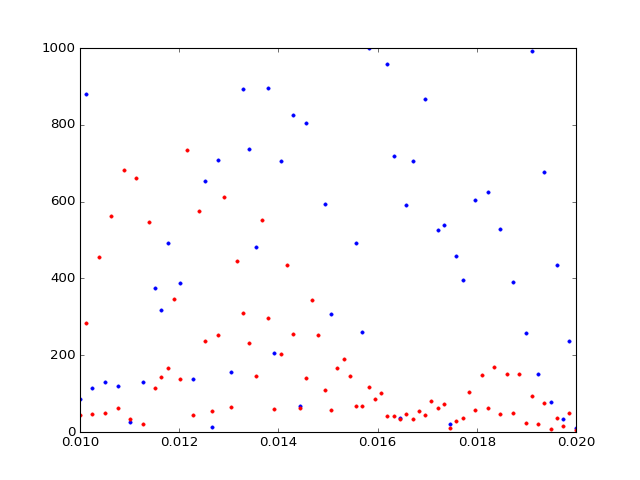

<function matplotlib.pyplot.grid>

In [155]:
fig = plt.figure()

plt.plot(w, np.absolute(U), '.b', w, np.absolute(Y), '.r')
plt.xlim(0.01,0.02)
plt.ylim(0,1000)
plt.grid

In [156]:
eps = 1e-4;
S = Y * np.conjugate(U) / (U * np.conjugate(U) + eps);

<IPython.core.display.Javascript object>


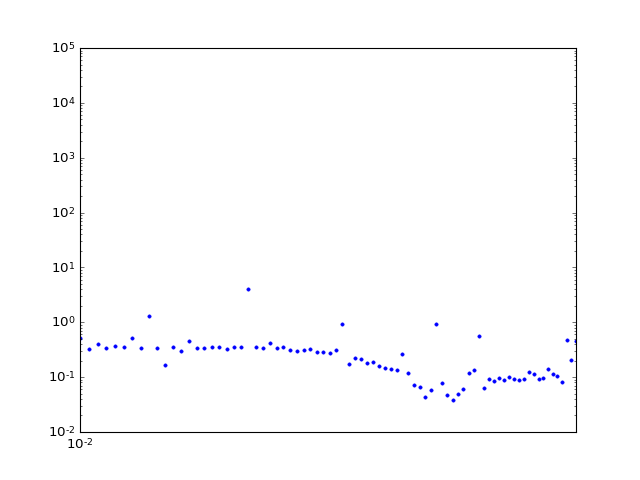

<IPython.core.display.Javascript object>


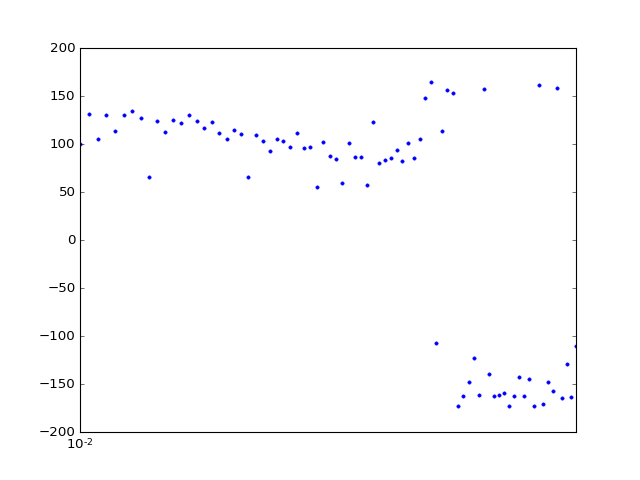

<function matplotlib.pyplot.grid>

In [158]:
fig = plt.figure()

plt.loglog(w, np.absolute(S), '.')
plt.xlim(0.01,0.02)
plt.grid

fig = plt.figure()

plt.semilogx(w, (180/np.pi)*np.angle(S), '.')
plt.xlim(0.01,0.02)
plt.grid

In [ ]:
fig = plt.figure()

plt.plot(clock,imu*360,'b.')
plt.xlabel('t (s)')
plt.ylabel('theta (Degrees)')
plt.grid()
#plt.xlim(0,3)
#plt.xlim(0,3)

In [ ]:
class Signal(Block):

    def __init__(self, x, repeat = False, *vars, **kwargs):
